# VAEでクラス識別ができないか検討してみる
- 目的
    - 生成モデルでクラス識別できるものかを確かめてみる
- 目標
    - VAEを使って2クラス分類タスクを解いてみる
- 手段
    - mnist手書き数字の任意の2文字を使う
    - 潜在空間を2次元にして可視化できるようにする
    - $p(z|C_K)$をガウス関数でパラメトリックにモデル化できるかやってみる
    - $p(C_k|z)$をベイズの公式で計算できるかやってみる

In [38]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import kde
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [39]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [40]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [41]:
# ラベルに対応するインデックスを取得する
indices_train = [np.where(y_train == i)[0] for i in range(10)]
indices_test = [np.where(y_test == i)[0] for i in range(10)]

# データをラベルごとに分割する
data_train = [x_train[indices_train[i]] for i in range(10)]
data_test  = [x_test[indices_test[i]] for i in range(10)]

In [42]:
latent_dim = 2
batch_size = 128
epochs = 10

In [43]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [44]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [45]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[0],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[0], None))

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 73.5312 - val_loss: 50.6687
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 50.0085 - val_loss: 47.9796
Epoch 3/10
47/47 [==============================] - 1s 15ms/step - loss: 43.6220 - val_loss: 42.5690
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 41.5100 - val_loss: 41.5716
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 40.2110 - val_loss: 37.6880
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 36.0089 - val_loss: 35.4652
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 34.9172 - val_loss: 34.8401
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 34.2744 - val_loss: 34.5290
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 33.7515 - val_loss: 33.8158
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 33.2942 - val_los

1/1 [==============================] - 0s 17ms/step


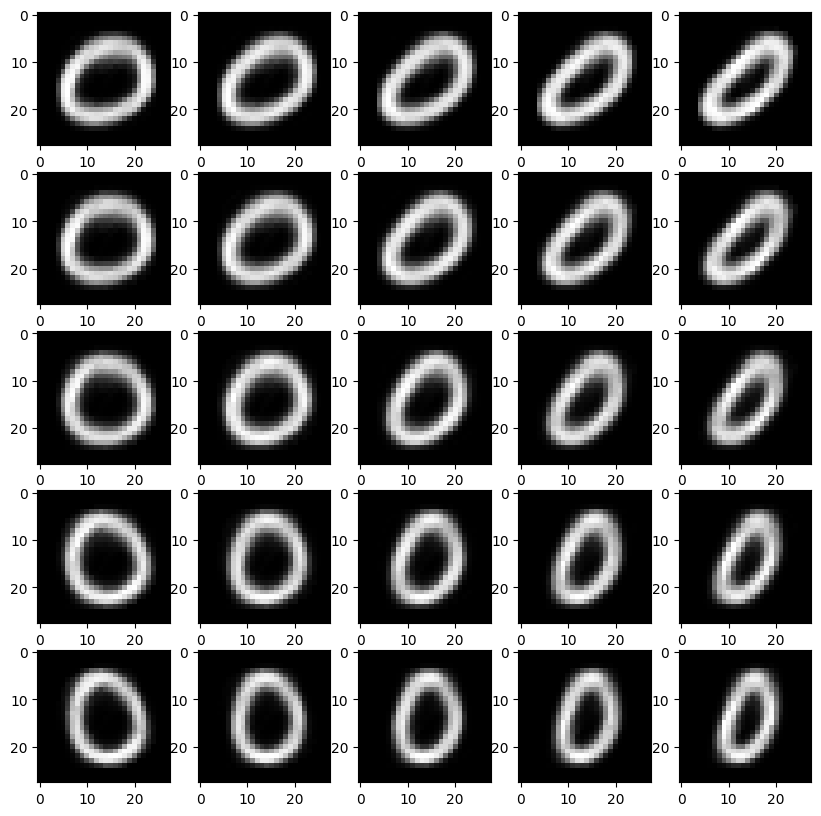

In [46]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [47]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
# z_mean, z_log_var, z = encoder.predict(data_test[0], batch_size=batch_size)
z_mean, z_log_var, z = encoder.predict(data_train[0], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

47/47 [==============================] - 0s 2ms/step
[[ 0.2700115  -0.25375777]
 [ 0.25011292 -0.3902306 ]
 [ 1.5509697   0.6654713 ]
 ...
 [ 1.0397575  -0.9463103 ]
 [ 1.3171264  -1.0229225 ]
 [ 0.9374387  -1.4620533 ]]
[[-2.9591558 -2.6199837]
 [-2.7001421 -2.3382237]
 [-2.1840563 -2.2375884]
 ...
 [-2.148101  -1.9086798]
 [-2.2063801 -2.0419176]
 [-2.46969   -1.7572455]]
[[ 0.27280727 -0.24553141]
 [ 0.22002107 -0.33263016]
 [ 1.5532882   0.6746566 ]
 ...
 [ 0.8251166  -0.9270611 ]
 [ 1.3635268  -1.0069445 ]
 [ 0.92780143 -1.5513098 ]]


/tmp/ipykernel_85021/1138288042.py:14: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


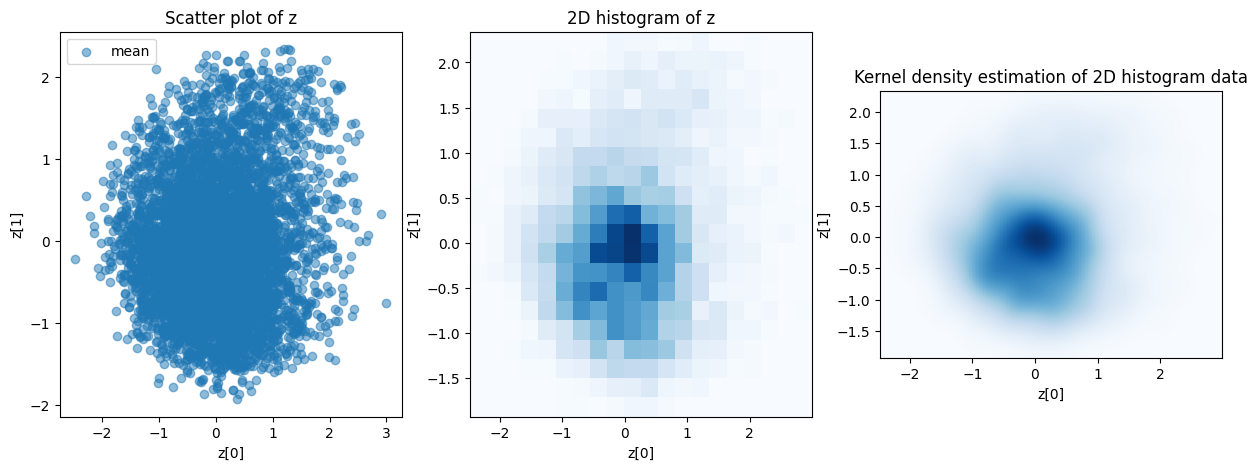

In [48]:
# x = z_mean[:, 0]
# y = z_mean[:, 1]
x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5, label='mean')
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()


Epoch 1/10
53/53 [==============================] - 1s 15ms/step - loss: 25.2785 - val_loss: 16.2137
Epoch 2/10
53/53 [==============================] - 1s 13ms/step - loss: 14.1886 - val_loss: 12.5051
Epoch 3/10
53/53 [==============================] - 1s 13ms/step - loss: 12.2679 - val_loss: 11.6639
Epoch 4/10
53/53 [==============================] - 1s 13ms/step - loss: 11.5711 - val_loss: 11.0607
Epoch 5/10
53/53 [==============================] - 1s 12ms/step - loss: 11.1677 - val_loss: 10.7138
Epoch 6/10
53/53 [==============================] - 1s 13ms/step - loss: 10.9177 - val_loss: 10.5896
Epoch 7/10
53/53 [==============================] - 1s 13ms/step - loss: 10.7552 - val_loss: 10.3744
Epoch 8/10
53/53 [==============================] - 1s 12ms/step - loss: 10.6212 - val_loss: 10.2772
Epoch 9/10
53/53 [==============================] - 1s 12ms/step - loss: 10.5276 - val_loss: 10.1430
Epoch 10/10
1/1 [==============================] - 0s 16ms/step


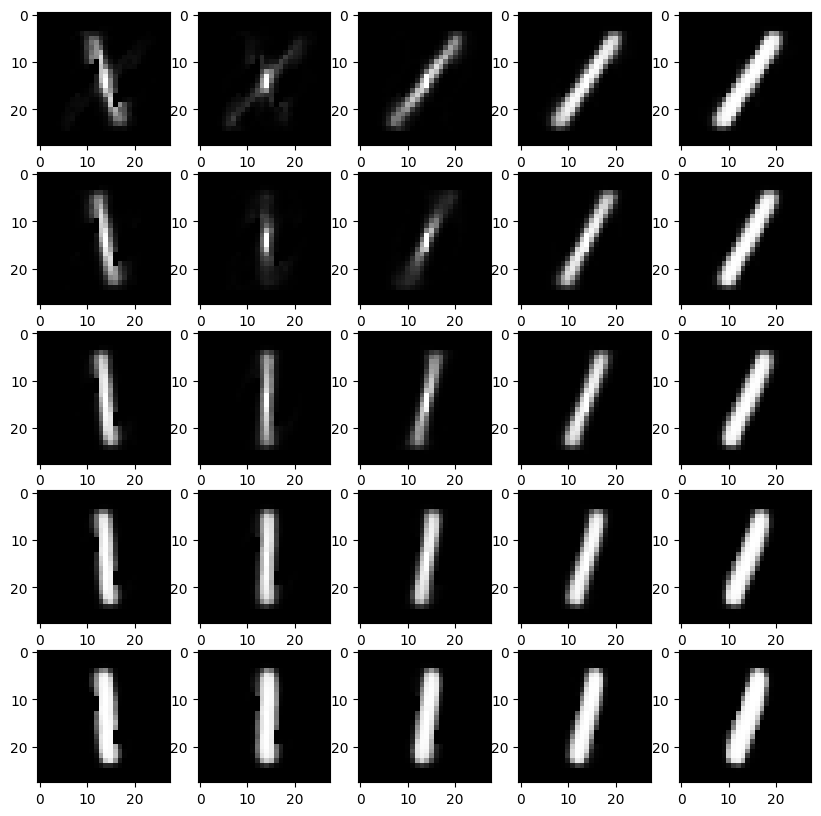

In [49]:
# モデルのパラメータを初期化する
K.clear_session()

vae.fit(data_train[1],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_test[1], None))

x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

53/53 [==============================] - 0s 3ms/step
[[ 0.6796133  -0.76222724]
 [-1.3585762   0.40402088]
 [-0.85878843  0.04649193]
 ...
 [ 0.4037922  -0.65787375]
 [ 0.0870473  -1.4344434 ]
 [ 0.1361261  -0.80060375]]
[[-2.3711374 -2.4826548]
 [-2.003735  -1.7913481]
 [-2.384371  -2.2284071]
 ...
 [-2.587352  -2.6249287]
 [-2.5121202 -2.3660662]
 [-2.5757015 -2.5046093]]
[[ 0.6846468  -0.7527899 ]
 [-1.4189564   0.5035456 ]
 [-0.8568908   0.05576194]
 ...
 [ 0.40857702 -0.6684079 ]
 [ 0.13060778 -1.4388758 ]
 [ 0.1278555  -0.7990798 ]]


/tmp/ipykernel_85021/2037728863.py:19: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  kernel = kde.gaussian_kde(values)


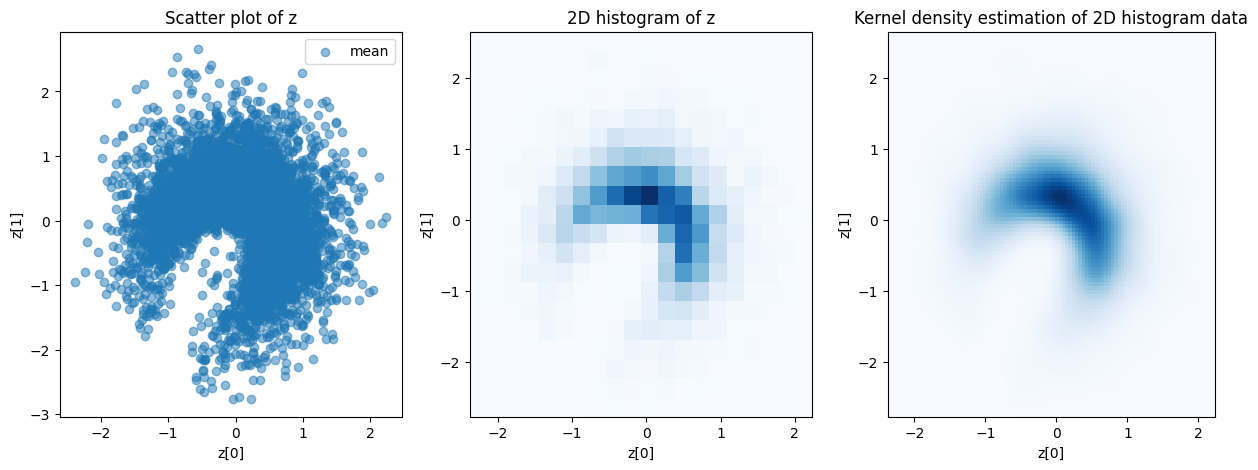

In [50]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_train[1], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

x = z[:, 0]
y = z[:, 1]

# Create a regular grid to evaluate the kernel density estimator
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = kde.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(x, y, alpha=0.5, label='mean')
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z")

axs[1].hist2d(x, y, bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z")

axs[2].imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# axs[2].plot(x, y, 'k.', markersize=2)
axs[2].set_xlim([xmin, xmax])
axs[2].set_ylim([ymin, ymax])
axs[2].set_xlabel("z[0]")
axs[2].set_ylabel("z[1]")
axs[2].set_title("Kernel density estimation of 2D histogram data")

plt.show()